<a href="https://colab.research.google.com/github/JK-c66/kasut_summer/blob/main/Week%201%20-%20Advanced%20Computer%20Vision/Day1/Lab1_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Action Recognition in Video Sequences using Deep Bi-directional LSTM with CNN Features

This Notebooks extracts features from videos in the YouTube Dataset using a pre-trained ResNet18 model. The extracted features can be used for training and testing LSTM models to perform action recognition.

We will be using the YouTube Dataset from the following link: https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php


Paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8121994

In [1]:
# Importing the required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import requests, zipfile, os

In [2]:
# Download and extract the dataset
dataset_url = "https://www.crcv.ucf.edu/data/YouTube_DataSet_Annotated.zip"
zip_file_path = "YouTube_DataSet_Annotated.zip"
extract_dir = "YouTube_DataSet_Annotated"

# Download dataset
with open(zip_file_path, 'wb') as f:
    f.write(requests.get(dataset_url, verify=False).content)

# Extract contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.remove(zip_file_path)  # Remove zip file
print("Download and extraction completed!")

data_dir = extract_dir + "/action_youtube_naudio"

if os.path.exists(data_dir + '/readme.txt'):
    os.remove(os.path.join(data_dir, 'readme.txt'))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.crcv.ucf.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Download and extraction completed!


In [3]:
# Define the number of frames to extract from each video
num_frames = 15

In [4]:
#TODO: Complete the definition of the transform to be applied on each frame
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# We will load a pre-trained model from the torchvision library and use it to extract features from the frames
# For this exercise, we will use ResNet-18 but you can use any other model from torchvision
resnet = models.resnet18(pretrained = True) #TODO: Load the pre-trained ResNet model and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
# We will use the model to extract the features from the frames, so we don't need the classification layer of the model
resnet_feat = nn.Sequential(*list(resnet.children())[:-1])  #TODO: Remove the classification layer from the ResNet model
resnet_feat = resnet_feat.to(device)
resnet_feat.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.5MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [7]:
# Create an empty list to store the features and labels
samples = []

resnet.eval()
# Loop over the videos in the dataset folder
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    print(label_dir)
    for sub_dir in os.listdir(label_dir):
        if sub_dir == 'Annotation':
            continue
        video_dir = os.path.join(label_dir, sub_dir)
        for video_file in os.listdir(video_dir):
            video_path = os.path.join(video_dir, video_file)
            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            frames = []
            while True:
                ret, frame = cap.read()
                if ret:
                    frame_count += 1
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = transform(frame).to(device)
                    frames.append(frame)
                    if frame_count == num_frames:
                        break
                else:
                    break
            cap.release()
            if len(frames) == num_frames:
                frames_tensor = torch.stack(frames)  # Stack the frames into a tensor of shape (num_frames, 3, 224, 224)
                # Extract the features using the pre-trained ResNet-18 model
                with torch.no_grad():
                    features_tensor = resnet_feat(frames_tensor)
                features_tensor = features_tensor.view(features_tensor.size(0), -1)  # Flatten the features tensor
                # Convert the features tensor to a numpy array
                features = features_tensor.cpu().numpy()
                # Append the features and label to the samples list
                samples.append((features, label))

# Shuffle the samples list
np.random.shuffle(samples)


YouTube_DataSet_Annotated/action_youtube_naudio/soccer_juggling
YouTube_DataSet_Annotated/action_youtube_naudio/trampoline_jumping
YouTube_DataSet_Annotated/action_youtube_naudio/basketball
YouTube_DataSet_Annotated/action_youtube_naudio/tennis_swing
YouTube_DataSet_Annotated/action_youtube_naudio/walking
YouTube_DataSet_Annotated/action_youtube_naudio/golf_swing
YouTube_DataSet_Annotated/action_youtube_naudio/volleyball_spiking
YouTube_DataSet_Annotated/action_youtube_naudio/biking
YouTube_DataSet_Annotated/action_youtube_naudio/diving
YouTube_DataSet_Annotated/action_youtube_naudio/swing
YouTube_DataSet_Annotated/action_youtube_naudio/horse_riding


In [8]:
#TODO: Split the samples into training and testing sets
split_ratio = 0.8
split_idx = int(len(samples) * split_ratio)

train_samples = samples[:split_idx]
test_samples = samples[split_idx:]

In [9]:
# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
test_features, test_labels = zip(*test_samples)

In [10]:
# Convert the labels to numerical labels using a LabelEncoder
le = LabelEncoder()
train_numerical_labels = le.fit_transform(train_labels)
test_numerical_labels = le.fit_transform(test_labels)
# Convert the features and labels arrays to numpy arrays
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = train_numerical_labels
test_features = np.array(test_features)
test_labels = test_numerical_labels

In [11]:
# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)

Train Features shape: (1319, 15, 512)
Train Labels shape: (1319,)
Test Features shape: (330, 15, 512)
Test Labels shape: (330,)


In [12]:
# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

In [13]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out


In [14]:
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional output

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional LSTM
        c0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional LSTM

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out


In [15]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))#.long()
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

test_features = torch.from_numpy(np.load('test_features.npy')).float()
test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()

In [28]:
# Complete the LSTM parameters
input_size = train_features.shape[2]  # Feature size from ResNet output
hidden_size = 128
num_classes = len(np.unique(train_labels))  # Number of unique classes in labels
num_frames = 15
num_layers = 2

In [29]:
# Define the training parameters
lr = 0.0001
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [34]:
# Instantiate the LSTM model (you can choose either LSTMClassifier or MultiLayerBiLSTMClassifier)
model = LSTMClassifier(input_size, hidden_size, num_classes)
# Or
# model = MultiLayerBiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)


In [35]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [36]:
# Train the LSTM model
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for i in range(0, len(train_features), num_frames):
        # Get a batch of 15 frames features and labels
        batch_features = train_features[i:i+num_frames].to(device)
        batch_labels = train_labels[i:i+num_frames].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_features)

        # Reshape batch_labels to match outputs if needed
        batch_labels = batch_labels.view(-1)  # Reshape to (batch_size,)

        # Calculate loss
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

    train_loss /= train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(test_features), num_frames):
            # Get a batch of 15 frames features and labels
            batch_features = test_features[i:i+num_frames].to(device)
            batch_labels = test_labels[i:i+num_frames].to(device)

            # Forward pass
            outputs = model(batch_features)

            # Reshape batch_labels to match outputs if needed
            batch_labels = batch_labels.view(-1)  # Reshape to (batch_size,)

            # Calculate loss
            loss = criterion(outputs, batch_labels)

            # Accumulate testing loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()

        test_loss /= test_total
        test_accuracy = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # Print training and testing results for each epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, train_loss, train_accuracy, test_loss, test_accuracy))


Epoch [1/10], Train Loss: 0.1584, Train Accuracy: 35.86%, Test Loss: 0.1554, Test Accuracy: 50.00%
Epoch [2/10], Train Loss: 0.1494, Train Accuracy: 57.70%, Test Loss: 0.1426, Test Accuracy: 58.79%
Epoch [3/10], Train Loss: 0.1375, Train Accuracy: 64.75%, Test Loss: 0.1346, Test Accuracy: 65.76%
Epoch [4/10], Train Loss: 0.1307, Train Accuracy: 71.72%, Test Loss: 0.1300, Test Accuracy: 74.24%
Epoch [5/10], Train Loss: 0.1259, Train Accuracy: 78.85%, Test Loss: 0.1265, Test Accuracy: 76.97%
Epoch [6/10], Train Loss: 0.1223, Train Accuracy: 81.80%, Test Loss: 0.1238, Test Accuracy: 80.00%
Epoch [7/10], Train Loss: 0.1195, Train Accuracy: 84.69%, Test Loss: 0.1213, Test Accuracy: 83.33%
Epoch [8/10], Train Loss: 0.1171, Train Accuracy: 87.57%, Test Loss: 0.1191, Test Accuracy: 86.67%
Epoch [9/10], Train Loss: 0.1149, Train Accuracy: 90.14%, Test Loss: 0.1172, Test Accuracy: 89.39%
Epoch [10/10], Train Loss: 0.1131, Train Accuracy: 92.72%, Test Loss: 0.1157, Test Accuracy: 91.52%


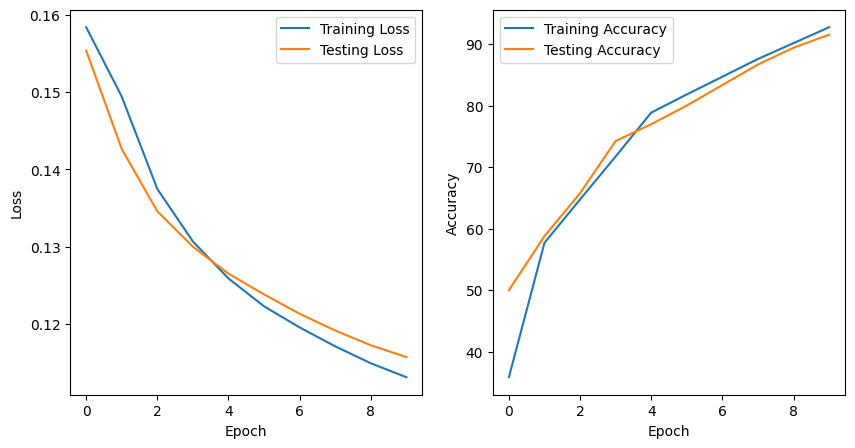

In [37]:
# Plot training and testing losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()